[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jochemvankempen/demos-data-science/blob/master/motor_output_prediction.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/jochemvankempen/demos-data-science/blob/master/motor_output_prediction.ipynb)

In this notebook, I will apply a recurrent neural network model [in pytorch](https://pytorch.org/) to predict the behavioural output (time series) based on neural activity recorded during a decision making task. 

## Dataset
I'll use the publicly available [dataset](https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406) that accompanied [this Nature paper](https://www.nature.com/articles/s41586-019-1787-x). Detailed information about the dataset can be found [here](https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files). 

## Paradigm
In this paradigm, mice were presented with visual stimuli of varying contrasts, which could appear on the left side, right side, both sides or neither side. Their task was to indicate which side had the highest contrast by moving this stimulus to the center of the screen. They did this by turning a wheel with their forepaws. If neither stimulus was present, they earned a reward for keeping the wheel still for 1.5 s. 

![](./steinmetz_paradigm.png)

## The analyses
This dataset contains the neural activity from approximately 30.000 neurons from many different brain areas (recorded across 39 sessions). We will select one recording session that contains neurons in the primary motor cortex, select the relevant neurons and predict the movement of the wheel using activity from these neurons. 

Make sure you run the notebook using a GPU. 

In [1]:
#@title Import packages and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks')

import numpy as np

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os, requests

rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
#@title GPU check
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE != "cuda":
  print("GPU is not enabled in this notebook")

In [4]:
#@title parameters
brain_area = 'MOp' # primary motor cortex

bin_size = 0.01 # data was binned in 10 ms bins 
time = np.arange(-0.5, 2, step=bin_size)


In [5]:
#@title Data retrieval

# There are three parts to this dataset, with a total of 39 sessions (13 sessions each). Here, we only load the first part.

url = ["https://osf.io/agvxh/download"]
# url.append("https://osf.io/uv3mw/download")
# url.append("https://osf.io/ehmw2/download")
fname = []
for j in range(len(url)):
  fname.append('steinmetz_part%d.npz'%j)

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [6]:
#@title Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

print(f'Loaded {len(alldat)} recording sessions')
print(f'data variable type: {type(alldat)}')
print(f'session variable type: {type(alldat[0])}')

Loaded 13 recording sessions
data variable type: <class 'numpy.ndarray'>
session variable type: <class 'dict'>


In [7]:
#@title helper functions
def get_sessions_by_brain_area(data, brain_area, bool_out=True):
  """get all Session IDs from Steinmetz dataset that have recordings from a particular brain region. 
  
    Parameters
    ---------- 
    data: numpy.ndarray
      ndarray with dict for each session 
    brain_area: string
      string with brain to look for
    bool_out: bool
      if True: return a boolean of all sessions, if False: return idx of sessions

    Returns
    -------
    output: list
      IDs or BOOLs of the sessions
  """
  num_sessions = len(data)
  session_bools = np.zeros((num_sessions), int)
  
  for k in range(num_sessions):
    session = data[k]
    brain_areas_in_session = session.get("brain_area")

    if brain_area in brain_areas_in_session:
      session_bools[k] = 1
      
  if bool_out:
    out = session_bools
  else:
    out = [i for i, x in enumerate(session_bools) if x]
    
  return out

def plot_loss(loss_train, loss_test):
  """plot train and test loss

    Parameters
    ----------
    loss_train: list
      list with train loss over model fit epochs
    loss_test: list
      list with test loss over model fit epochs
  """
  fig, ax = plt.subplots(figsize=(10,5))

  n_epochs = len(loss_train)

  ax.plot(np.arange(n_epochs), loss_train, linestyle='--', color='b', label='train')
  ax.plot(np.arange(n_epochs), loss_test, linestyle='-', color='b', label='test')

  ax.set_xlabel('epochs')
  ax.set_ylabel('MSE loss')
  ax.set_title(f'Train and test loss')
  ax.legend()

  plt.show()

  print(f'Final MSE test loss: {loss_test[-1]}')

def plot_prediction_examples(test_data, test_predictions, n=5):
  """plot examples of data and predictions 

    Parameters
    ----------
    test_data: np.ndarray
      array with test data
    test_predictions: np.ndarray
      array with test predictions 

    n: int
      int indicating how many examples to plot, defaults to 5
  """

  trial = np.random.choice(a=test_data.shape[0], size=n)

  fig, ax = plt.subplots(figsize=(8,2.5*len(trial)), nrows=len(trial), ncols=1, sharex='col')

  for index, t in enumerate(trial):
    ax[index].plot(time, test_data[t,:,:], label='data')
    ax[index].plot(time, test_predictions[t,:,:], label='prediction')

    ax[index].set_ylabel('Wheel speed')

  ax[index].set_xlabel('Time from stimulus onset')
  ax[index].legend()

  plt.show()

In [8]:
#@title Identify sessions with the defined brain_area

sessions = get_sessions_by_brain_area(data=alldat, 
                                      brain_area=brain_area, 
                                      bool_out=False)

print(f'Sessions that contain brain area {brain_area}: {sessions}')

# select a single session to analyse
session = sessions[0]


Sessions that contain brain area MOp: [10]


In [9]:
# @title Print keys (and sizes) in dict of session
print(alldat[session].keys())

print(f"variable 'wheel' is shape {alldat[session]['wheel'].shape}")
print(f"variable 'spks' is shape {alldat[session]['spks'].shape}")

print(f"unique brain areas: {np.unique(alldat[session]['brain_area'])}")
print(f"number of cells in brain area {brain_area}: {np.sum(alldat[session]['brain_area']==brain_area)}")

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
variable 'wheel' is shape (1, 342, 250)
variable 'spks' is shape (857, 342, 250)
unique brain areas: ['CP' 'LSc' 'LSr' 'MOp' 'PT' 'root']
number of cells in brain area MOp: 447


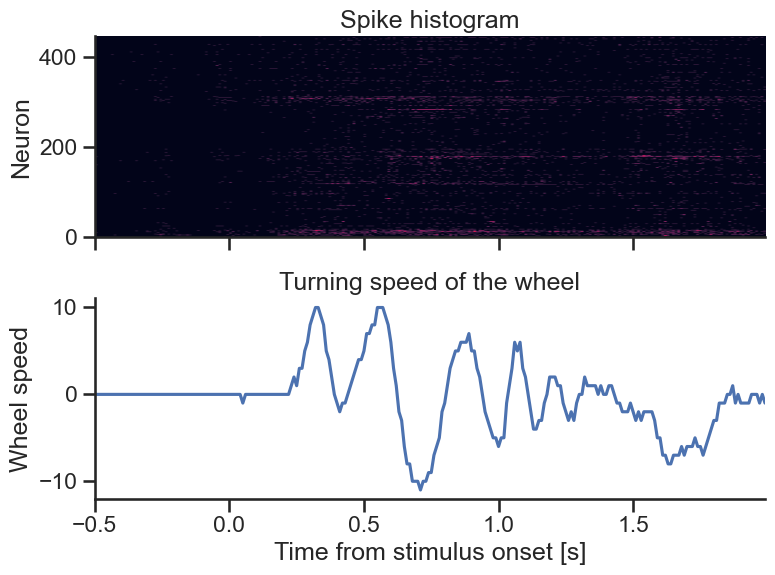

In [10]:
# @title plot spike histogram and motor output, single trial example

trial = 0

fig, ax = plt.subplots(figsize=(8,6), nrows=2, ncols=1, sharex='col')

# spike histogram
index = alldat[session]['brain_area']==brain_area
ax[0].imshow(alldat[session]['spks'][index,trial,:],
             aspect='auto',
             extent=[time[0],time[-1],0,np.sum(index)])
ax[0].set_title('Spike histogram')
ax[0].set_ylabel('Neuron')

# motor ouput
ax[1].plot(time,alldat[session]['wheel'][0,trial,:])
ax[1].set_title('Turning speed of the wheel')
ax[1].set_xlabel('Time from stimulus onset [s]')
ax[1].set_ylabel('Wheel speed')

plt.show()

In [71]:
# @title model train function
def traintest(features, labels, model, 
              loss_fun=None, optimizer=None, device='cuda',
              n_epochs=100, test_size=0.2, lr=0.001, weight_decay=0.01, batch_size=1,
              ):

  """Training function

    Parameters
    ----------
    features: torch.Tensor
      features (input) with shape torch.Size([num_samples, num_times, num_units])
    labels: torch.Tensor
      labels (targets) with shape torch.Size([n_samples, 1])
    model: torch nn.Module
      the neural network
    loss_fun: function
      loss function
    optimizer: function
      optimizer
    device: str
      string indicating which device to use
    n_epochs: int
      number of training iterations
    test_size: float
      float indicating the proportion of test trials
    lr: float
      float indicating the learning rate of the model (only used if optimizer=None)
    weight_decay: float
      float indicating the regularization parameter of the optimizer (only used if optimizer=None)
    batch_size: int
      batch size used for training. If batch_size==-1, the full train/test set is used.

    Returns
    -------
    list
      record of train losses
    list
      record of test losses  
    np.ndarray
      test data
    np.ndarray 
      test predictions
  """

  # check input, define loss, optimizer and convert data to tensors
  if loss_fun is None:
    loss_fun = nn.MSELoss().to(device)
  if optimizer is None:
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay )
    # optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr, weight_decay=weight_decay )
    # optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, weight_decay=weight_decay )
  if type(labels) == np.ndarray:
    labels = torch.tensor(labels).float()
  if type(features) == np.ndarray:
    features = torch.tensor(features).float()

  # get shape
  num_trials, num_times, num_units = features.shape
  
  # init loss lists
  loss_record_train = []  # keeping records of loss
  loss_record_test = []  # keeping records of loss

  # define train and test set
  train_trials, test_trials, train_labels, test_labels = train_test_split(features, labels, test_size=test_size)

  # transfer data & model to GPU/TPU device 
  train_trials, test_trials = train_trials.to(device), test_trials.to(device)
  train_labels, test_labels = train_labels.to(device), test_labels.to(device)
  model = model.to(device)

  # define batch sizes
  if batch_size==(-1):
    train_batch_size = len(train_trials)
    test_batch_size = len(test_trials)
    print(f'train/test batch size {[train_batch_size, test_batch_size]}')
  else:
    train_batch_size = batch_size
    test_batch_size = batch_size

  # loop over epochs, keep track of progress using tqdm
  for i in tqdm(range(n_epochs)):
    
    # set gradients to 0
    optimizer.zero_grad()  

    # intialise train and test predictions
    train_predictions = torch.empty(((len(train_trials)), num_times, 1), dtype=torch.float, requires_grad=False, device=device)
    test_predictions = torch.empty(((len(test_trials)), num_times, 1), dtype=torch.float, requires_grad=False, device=device)

    # training
    for batch in range(0, len(train_trials), train_batch_size):
      
      # define batch 
      input = train_trials[batch:batch+train_batch_size] 

      # Compute and store model prediction (output) for each batch
      batch_predictions = model(input) 
      train_predictions[batch:batch+train_batch_size,:,:] = batch_predictions 

    # Compute the training loss
    train_loss = loss_fun(train_predictions, train_labels)  

    # Compute gradients (backward pass)
    train_loss.backward()  
    train_loss.detach()

    # update parameters (optimizer takes a step)
    optimizer.step()  

    # store training loss over epochs
    loss_record_train.append(train_loss.item())

    # testing
    for batch in range(0, len(test_trials), test_batch_size):

      # define batch 
      input = test_trials[batch:batch+test_batch_size] 

      # Compute model prediction (output)
      batch_predictions = model(input)  
      
      # store
      test_predictions[batch:batch+test_batch_size,:,:] = batch_predictions 

    # Compute the testing loss
    test_loss = loss_fun(test_predictions, test_labels)  
    loss_record_test.append(test_loss.item())
  
  return loss_record_train, loss_record_test, test_labels.cpu().numpy(), test_predictions.detach().cpu().numpy()

In [22]:
# @title Neural net definition: RNN
class MyRNN(nn.Module):
  def __init__(self, 
               unit_size, embed_size, 
               hidden_size, output_size,
               hidden_type='RNN',
               num_layers=1):  
    super(MyRNN, self).__init__()

    # params
    self._unit_size = unit_size # number of units/cells
    self._embed_size = embed_size # low-dimensional embedding of cells
    self._hidden_size = hidden_size # number of recurrent units
    self._output_size = output_size # number of timeseries as output
    self._hidden_type = hidden_type # type of recurrent unit
    self._num_layers = num_layers # number of recurrent layers

    # layers
    self.fc_embed = nn.Linear(unit_size, embed_size)

    print(f'using recurrent unit type: {hidden_type}')
    if hidden_type=='RNN':
      self.rnn = nn.RNN(embed_size, hidden_size, 
                        num_layers=num_layers, batch_first=True) 
    elif hidden_type=='LSTM':
      self.rnn = nn.LSTM(embed_size, hidden_size, 
                        num_layers=num_layers, batch_first=True) 
    elif hidden_type=='GRU':
      self.rnn = nn.GRU(embed_size, hidden_size, 
                        num_layers=num_layers, batch_first=True)    

    self.fc_out = nn.Linear(hidden_size, output_size)

  def forward(self, input, verbose=False): 

    # Neuron Embedding
    embed_out = self.fc_embed(input)
    if verbose: print(f'embed out:{embed_out.shape}')

    # RNN
    rnn_out,_ = self.rnn(embed_out)
    if verbose: print(f'rnn out:{rnn_out.shape}')

    # Output
    fc_out = self.fc_out(rnn_out)
    if verbose: print(f'fc1 out:{fc_out.shape}')

    return fc_out


In [23]:
# @title data transformation

# find units in relevant brain area
index = alldat[session]['brain_area']==brain_area

num_units, num_trials, num_times = alldat[session]['spks'][index,:,:].shape

# select relevant units, reorder dims to (trials (batch size), times, units)
spks = alldat[session]['spks'][index,:,:].transpose((1,2,0))
print(f"spks shape: {spks.shape}")

wheel = alldat[session]['wheel'][:,:,:].transpose((1,2,0))
print(f"wheel shape: {wheel.shape}")


spks shape: (342, 250, 447)
wheel shape: (342, 250, 1)


In [82]:
# @title Initialise model and display test forward pass
net = MyRNN(unit_size=num_units,
            embed_size=200, # low-dimensional embedding of neuron dimension
            hidden_size=100, # RNN units
            output_size=1, # single timeseries,
            num_layers=1,
            hidden_type='RNN'
            )

test_batch_size = 10
print(f"test batch size: {test_batch_size}")
test_spks = torch.tensor(spks[:test_batch_size,:,:]).float()
print(f"input data shape: {test_spks.shape}")

forward_pass = net.forward(input=test_spks, verbose=True)
print(f"output data shape: {forward_pass.shape}")


using recurrent unit type: RNN
test batch size: 10
input data shape: torch.Size([10, 250, 447])
embed out:torch.Size([10, 250, 200])
rnn out:torch.Size([10, 250, 100])
fc1 out:torch.Size([10, 250, 1])
output data shape: torch.Size([10, 250, 1])


In [83]:
# @title fit model to data
losses_train, losses_test, test_labels, test_predictions = traintest(features=spks,
                                                                      labels=wheel,
                                                                      model=net,
                                                                      n_epochs=250,
                                                                      test_size=0.2,
                                                                      lr=0.001,
                                                                      weight_decay=0.01, 
                                                                      batch_size=-1,
                                                                      device=DEVICE,
                                                                      )


train/test batch size [273, 69]


100%|██████████| 250/250 [00:19<00:00, 12.77it/s]


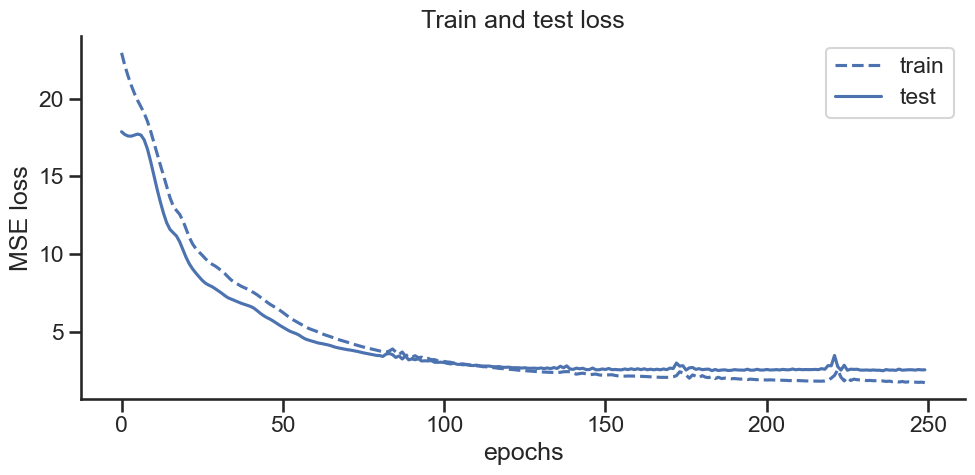

Final MSE test loss: 2.550307512283325


In [84]:
plot_loss(losses_train,losses_test)


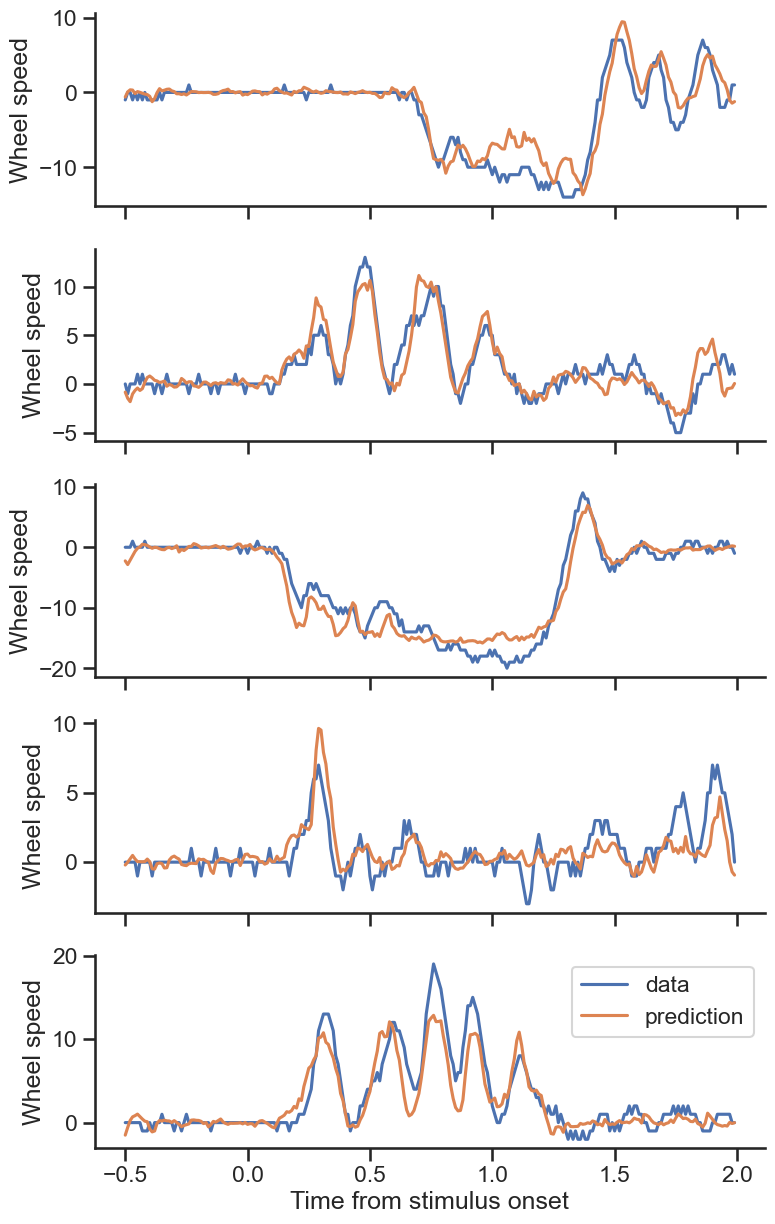

In [85]:
plot_prediction_examples(test_labels,test_predictions,n=5)